In [12]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import random
from sklearn.metrics.pairwise import cosine_similarity
import math
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import psycopg2 as pg2
import psycopg2.extras as pgex
this_host='34.211.59.66'
this_user='postgres'
this_password='postgres'
conn = pg2.connect(host = this_host, 
                        user = this_user,
                        password = this_password)

sql_select = '''select created_at, location, tweet_content, cleaned_tweet, hashtags from tweets;'''

cur = conn.cursor(cursor_factory=pgex.RealDictCursor)
cur.execute(sql_select)
rows = cur.fetchall()
conn.close()
df = pd.DataFrame(rows)
df.reset_index(inplace = True)

In [3]:
import pickle
!pip install redis
import redis
redis_ip = '34.211.59.66'
r = redis.StrictRedis(redis_ip)
r.keys()

    100% |████████████████████████████████| 61kB 2.1MB/s ta 0:00:011
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


[b'tweet_tfidf_fit_transform',
 b'hashtags_countvec_fit_transform',
 b'tweet_SVD_fit',
 b'tweet_tfidf_fit',
 b'hashtags_tfidf_fit_transform',
 b'hashtags_countvec_fit']

In [4]:
TFIDF_fit = pickle.loads(r.get('tweet_tfidf_fit'))
SVD_fit = pickle.loads(r.get('tweet_SVD_fit'))

In [5]:
def event_tweet_count(event):
    event_tweet = df[df['cleaned_tweet'].str.contains((event))]
    return len(event_tweet)

In [6]:
def tweets_event_ab_test(event):
    event_tweet = df[df['cleaned_tweet'].str.contains((event))]
    event_tweet.reset_index(inplace = True)
    
    A_index = list(range(event_tweet.shape[0]))
    random.shuffle(A_index)
    
    n = int(round((event_tweet_count(event))*0.2,0))
    A1_index = []
    for i in range(n):
        A1_index.append(A_index.pop())
    
    A1 = event_tweet.iloc[A1_index,:]
    A1_vec = np.array([SVD_fit.transform(TFIDF_fit.transform([i])).ravel() for i in A1['cleaned_tweet']])

    A2 = event_tweet.iloc[A_index,:] 
    #A2.reset_index(inplace = True)
    A2_vec = np.array([SVD_fit.transform(TFIDF_fit.transform([i])).ravel() for i in A2['cleaned_tweet']])
    non_event_tweet = df[~df['cleaned_tweet'].str.contains(('event'))]
    non_event_tweet.reset_index(inplace = True)
    
    B_index = list(range(non_event_tweet.shape[0]))
    random.shuffle(B_index)
    n = n
    B1_index = []
    for i in range(n):
        B1_index.append(B_index.pop())
    m = A2.shape[0]
    B2_index = []
    for i in range(m):
        B2_index.append(B_index.pop())  
    
    B1 = non_event_tweet.iloc[B1_index,:]
    B1_vec = np.array([SVD_fit.transform(TFIDF_fit.transform([i])).ravel() for i in B1['cleaned_tweet']])
    
    B2 = non_event_tweet.iloc[B2_index,:]
    B2_vec = np.array([SVD_fit.transform(TFIDF_fit.transform([i])).ravel() for i in B2['cleaned_tweet']])
    
    A1_vec_mean = np.mean(A1_vec, axis=0)
    A2_vec_mean = np.mean(A2_vec, axis=0)
    B1_vec_mean = np.mean(B1_vec, axis=0)
    B2_vec_mean = np.mean(B2_vec, axis=0)
    
    a1a2 = cosine_similarity(A1_vec_mean.reshape(1,-1),A2_vec_mean.reshape(1,-1))[0][0]
    b1b2 = cosine_similarity(B2_vec_mean.reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0]
    a1b1 = cosine_similarity(A1_vec_mean.reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0]
    a2b2 = cosine_similarity(A2_vec_mean.reshape(1,-1),B2_vec_mean.reshape(1,-1))[0][0]
   
    a2_consim_list = []
    for i in range(min(n,m)):  
        a2_consim_list.append(cosine_similarity(A2_vec[i].reshape(1,-1),A1_vec_mean.reshape(1,-1))[0][0])
    a2_mean = np.mean(np.array(a2_consim_list))
    a2_std = np.std(np.array(a2_consim_list))
    
    b2_consim_list = []
    for i in range(min(n,m)):  
        b2_consim_list.append(cosine_similarity(B2_vec[i].reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0])
    b2_mean = np.mean(b2_consim_list)
    b2_std = np.std(b2_consim_list)
    
    a1b2_consim_list = []
    for i in range(min(n,m)):  
        a1b2_consim_list.append((cosine_similarity(B2_vec[i].reshape(1,-1),A1_vec_mean.reshape(1,-1))[0][0]))
    a1b2_mean = np.mean(a1b2_consim_list)
    a1b2_std = np.std(a1b2_consim_list)
    
    print('A1|A2: ',a1a2,'\n'
                'B1|B2: ',b1b2, '\n\n'
                'A1|B1: ',a1b1, '\n'
                'A2|B2: ', a2b2, '\n\n'
                'Cosine Similarity Mean of A2 to A1', a2_mean, '\n'
                'Cosine Similarity Mean of B2 to B1', b2_mean, '\n'
                'Cosine Similarity Mean of B2 to A1', a1b2_mean, '\n\n'
                'Cosine Similarity STD of A2 to A1', a2_std, '\n'
                'Cosine Similarity STD of B2 to B1', b2_std, '\n'
                'Cosine Similarity STD of B2 to A1', a1b2_std, '\n'                 
                )
    
    return a2_consim_list, b2_consim_list

In [101]:
def check_score_cluster(event,check_by_score = .7,high_score = .9):
    event_tweet = df[df['cleaned_tweet'].str.contains((event))]
    event_tweet.reset_index(inplace = True, drop=True)
    A_index = list(range(event_tweet.shape[0]))
    random.shuffle(A_index)

    n = int(round((event_tweet_count(event))*0.5,0))
    A1_index = []
    for i in range(n):
        A1_index.append(A_index.pop())

    A1 = event_tweet.iloc[A1_index,:]
    A1.reset_index(inplace = True, drop=True)
    A1_vec = SVD_fit.transform(TFIDF_fit.transform(A1['cleaned_tweet']))

    A2 = event_tweet.iloc[A_index,:] 
    A2_vec = SVD_fit.transform(TFIDF_fit.transform(A2['cleaned_tweet']))
    A1_vec_mean = np.mean(A1_vec, axis=0)
    A2_vec_mean = np.mean(A2_vec, axis=0)

    consim_twt_list = []
    for i in range(len(A1)):  
        consim_twt_list.append((cosine_similarity(A1_vec[i].reshape(1,-1),A2_vec_mean.reshape(1,-1))[0][0], A1['cleaned_tweet'][i]))
    #pd.options.display.max_colwidth = 200
    result = pd.DataFrame(consim_twt_list, columns = ['score','tweet'])
    cluster1 = result[result['score']>high_score].sort_values('score', ascending = False)
    cluster2 = result[((result['score']<(check_by_score+.05)) & (result['score']>(check_by_score-.05)))]\
                .sort_values('score', ascending = False)
    return pd.concat([cluster1.reset_index().head(30), cluster2.reset_index().head(30)], axis=1)

In [122]:
def Top_scored_tweets_in_B(event, n = 10000):
    A = df[df['cleaned_tweet'].str.contains((event))]
    A.reset_index(inplace = True, drop=True)
    A_vec = SVD_fit.transform(TFIDF_fit.transform(A['cleaned_tweet']))
    A_vec_mean = np.average(A_vec, axis=0)
       
    B = df[~df['cleaned_tweet'].str.contains((event))]
    B_index = list(range(B.shape[0]))
    random.shuffle(B_index)
    n = n
    B1_index = []
    for i in range(n):
        B1_index.append(B_index.pop())
        
    B1 = B.iloc[B1_index,:]
    B1.reset_index(inplace = True, drop=True)
    B1_vec = SVD_fit.transform(TFIDF_fit.transform(B1['cleaned_tweet']))
    
    consim_twt_list = []
    for i in range(n):  
        consim_twt_list.append((cosine_similarity(B1_vec[i].reshape(1,-1),A_vec_mean.reshape(1,-1))[0][0], B1['cleaned_tweet'][i]))
    pd.options.display.max_colwidth = 200
    result = pd.DataFrame(consim_twt_list, columns = ['score','tweet'])
    cluster = result[result['score']>.7].sort_values('score', ascending = False)
    pd.set_option('display.max_colwidth', -1)
    return cluster.head(20)

Event Tweets (A):  2529
A1|A2:  0.986436225574 
B1|B2:  0.886141013849 

A1|B1:  0.240283211609 
A2|B2:  0.378447077011 

Cosine Similarity Mean of A2 to A1 0.322342576592 
Cosine Similarity Mean of B2 to B1 0.146712601409 
Cosine Similarity Mean of B2 to A1 0.0614615580703 

Cosine Similarity STD of A2 to A1 0.226803815002 
Cosine Similarity STD of B2 to B1 0.13479772 
Cosine Similarity STD of B2 to A1 0.107665746042 



(-0.1, 1)

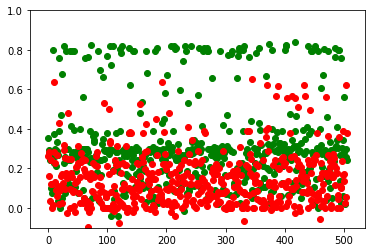

In [53]:
print('Event Tweets (A): ', event_tweet_count('paris|climate'))
A, B = tweets_event_ab_test('paris|climate')
plt.scatter(range(len(A)), A, c = 'g')
plt.scatter(range(len(B)), B, c = 'r')
plt.ylim(-.1,1)

In [91]:
check_score_cluster('paris|climate',.3, .7)

,index,score,tweet,index,score,tweet
0,1174,0.829395,did they think elon musk would convince trump to stay in the climate agreement? trump doesn't listen to anyone richer &amp; smarter than he is.,1181,0.349896,"more juvenile anger from you instead of intellectual retort just convinces the world climate change is a hoax,"
1,967,0.810253,"#andersoncooper on #climate #change: we still don't know what the trump believes, and we've been asking",1070,0.349835,i pledge allegiance to the united states climate alliance and to the people of the world to which the planet belong…
2,1250,0.806191,why trump withdrew from the unfair paris climate accord liberals and democrats don't care about america,134,0.349798,"⚡️ “police shoot man who attacked officers at notre dame, paris”"
3,684,0.804244,only reason trump don't care/believe in climate change cause he not gonna be on this earth in the next 10-15 years,1193,0.349439,makes no sense to pull out of the paris agreement.... is anyone in the wh thinking of the future. god save us from this president.
4,406,0.799303,lmao trump and 22 other republican congressman don't believe in climate change... so we're like 100% behind nicarag…,283,0.349436,yep...paying off your debt 2 that china bank u owe...by taking us out of the paris dea…
5,859,0.799235,i don't know why everybody is worried about barron withdrawing from the climate change deal shows trump cares about no childs future,572,0.349322,#paris accord is unfair. us gives away $634b and china the #1 world polluter and currency manipulato…
6,916,0.797967,"i can't tell you how many trump supporting conservatives have told me how they ""don't know a lot"" about climate change. but that's the gag!",846,0.349315,paris agreement is unfair. why should the us give away $634b and china the #1 world polluter and curr…
7,122,0.796706,u know why? they cued up the climate story for all the trump bash bs &amp; oops the world did not cooperate. ch…,1168,0.349229,climate evangelists are taking over your local weather forecast
8,178,0.794967,"""president trump has pulled out of the paris climate accord. a frustrated paris climate accord was unavailable for…",418,0.348249,"""climate change is a hoax."" the world is flat. aka"
9,1162,0.794783,trump announces america is leaving the paris climate accord... and that he intends to look at rejoining the paris climate accord.,274,0.348173,"hey liberals stop crying over this bs climate deal, or we might actually drown from all your damn tears💦"


Event Tweets (A):  891
A1|A2:  0.996164981486 
B1|B2:  0.908649436492 

A1|B1:  0.0375735821127 
A2|B2:  0.0763144769162 

Cosine Similarity Mean of A2 to A1 0.69985940294 
Cosine Similarity Mean of B2 to B1 0.155310949392 
Cosine Similarity Mean of B2 to A1 0.0188016092223 

Cosine Similarity STD of A2 to A1 0.247862907487 
Cosine Similarity STD of B2 to B1 0.148705983371 
Cosine Similarity STD of B2 to A1 0.0566425474332 



(-0.1, 1.2)

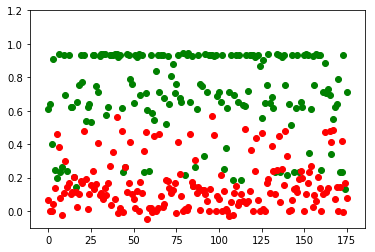

In [54]:
print('Event Tweets (A): ', event_tweet_count('nbafinal'))
A, B = tweets_event_ab_test('nbafinal')
plt.scatter(range(len(A)), A, c = 'g')
plt.scatter(range(len(B)), B, c = 'r')
plt.ylim(-.1,1.2)

In [102]:
#check high score tweets (>0.9) versus tweets with clustered scores 
check_score_cluster('nbafinal',.7)

,index,score,tweet,index,score,tweet
0,353,0.947085,i'm so glad durant is on the #gsw...just cuz i hate lebron #nbafinals,267,0.749490,great #brother #sister time yay #warriors #nbafinals
1,405,0.941973,replacing harrison barnes with kevin durant is like replacing a step ladder with kevin durant #nbafinals,202,0.748800,"kawhi is at home laughing, or probably not thinking he was killing this warriors team all by himself #nbafinals"
2,321,0.941912,and take ur l's like a man #nbafinals #goldenstate #gowarriors,133,0.746092,#nbafinals looks like is gonna get his first nba champ lol
3,328,0.940594,two hot nights for durant. give the man the finals mvp. #nbafinals,131,0.744732,"yo , who keeps track of nba statistics? lol some of them are ridiculous! #nbafinals"
4,281,0.940121,i told you before that kd has the most pressure on a player in the #nbafinals since lebron's 1st w/miami. it isn't affecting him so far.,241,0.741669,"since my room mate and i live in l.a. we gunna try to get 2 game 2 of the #nbafinals , that would be so lit #nbafinals2017"
5,205,0.939700,i feel like durants hard foul on lebron there is gonna wake a sleeping beast #nbafinals,163,0.735488,what if lebron said f it and jumped in this fight after the game? lol #nbafinals #nba #cavsvswarriors #fight
6,406,0.939584,lebron james going back to the lab #nbafinals #believeland #wewasherebeforealready #cavsin7,13,0.733099,when people say the cavs are still gonna beat the dubs #nbafinals
7,262,0.939565,reporter: if there was one thing that stands out to you about them [from last year]...what would it be? lebron: kd #nbafinals,260,0.732528,"the cavs black jerseys look really nice, too bad we only get to see them for 2 more games #nbafinals"
8,326,0.939538,lebron is trying to get kd to react for an offensive foul. wait for the flop #nbafinals,268,0.732274,warriors in 4...lol..jk #nbafinals
9,61,0.939526,kd full on just pushed lebron #nbafinals,145,0.730758,is it time to start pondering if the #cavs will get swept? durant changed everything #nbafinals


In [85]:
check_score_cluster('nbafinal',.2)

,index,score,tweet,index,score,tweet
0,74,0.952249,#durant over #lebron #nbafinals prediction 6/4/17: durant will finish with more rings than lebron,20,0.249638,want this ring and he's playing like it! #nbafinals2017
1,254,0.948539,i'm so glad durant is on the #gsw...just cuz i hate lebron #nbafinals,115,0.248378,"have i ever tweeted about how much i hate sleeved basketball jerseys. well, i hate them. a lot. #nbafinals2017"
2,291,0.945730,lebron gonna be lebron #nbafinals,375,0.248077,should have to change his name after that exchange. #therecanbeonlyone #clevsgsw #nbafinals2017
3,153,0.943091,"curry takes lebron to the hoop: ""this is where you put the basketball"" #nbafinals #gsw",278,0.245795,i believe and i told y'all how the #nbafinals2017 was going to go down on this episode #gswvscavs
4,392,0.942490,damn steph schoolin' lebron to the hole. #game2 #nbafinals,282,0.245366,are toying with right now letting them think they've got a chance... #nbafinals2017
5,61,0.942451,replacing harrison barnes with kevin durant is like replacing a step ladder with kevin durant #nbafinals,183,0.245293,low-key waiting for the #lakers to be as good as any of these teams #nbafinals2017 #wewillrebuild
6,85,0.942097,"if there is a lebron james and kevin durant rap song in the universe, and it leaks, my head will explode. #nbafinals",384,0.245247,"""momma there goes that man!"" -- marc jackson of #nbafinals2017"
7,24,0.941990,and take ur l's like a man #nbafinals #goldenstate #gowarriors,57,0.245155,made look stupid af just now can't touch this #nbafinals2017 lit
8,363,0.941051,kd full on just pushed lebron #nbafinals,28,0.245012,what's the score? i'm at work #nbafinals2017
9,75,0.941036,lebron james going back to the lab #nbafinals #believeland #wewasherebeforealready #cavsin7,220,0.244848,people forget how great richard jefferson used to be. great game. #nbafinals2017


Event Tweets (A):  200
A1|A2:  0.992971528958 
B1|B2:  0.39268741903 

A1|B1:  0.0399557167429 
A2|B2:  0.233638119321 

Cosine Similarity Mean of A2 to A1 0.657382531179 
Cosine Similarity Mean of B2 to B1 0.0743382065086 
Cosine Similarity Mean of B2 to A1 0.0665733634911 

Cosine Similarity STD of A2 to A1 0.322490114059 
Cosine Similarity STD of B2 to B1 0.0818812044923 
Cosine Similarity STD of B2 to A1 0.12351817846 



(-0.1, 1.2)

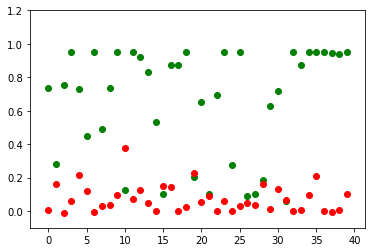

In [55]:
print('Event Tweets (A): ', event_tweet_count('travel ban|travelban'))
A, B = tweets_event_ab_test('travel ban|travelban')
plt.scatter(range(len(A)), A, c = 'g')
plt.scatter(range(len(B)), B, c = 'r')
plt.ylim(-.1,1.2)

In [87]:
check_score_cluster('travel ban|travelban',.7)

,index,score,tweet,index,score,tweet
0,55,0.978371,"trump keeps tweeting using the term ""travel ban"" despite the justice dept telling everyone this isnt a travel ban. u cant make this shit up.",30.0,0.749760,"very sorry for the victims of london. mr. trump before you talk about the travel ban, say you are sorry about the victims."
1,32,0.929737,#whitehouse asks us supreme court to #reinstate #travel ban on people from majority #muslim #countries,82.0,0.746363,"to recap the recap: president admits travel ban is a ban, 1st move after attack is to score political points &amp; appa…"
2,33,0.927686,how can a travel ban demonize anything what it is is you don't want to protect your lov…,15.0,0.745130,"no,tiny correction patriot...we needed a travel band yesterday too❤&amp; every day after...forever"
3,39,0.927601,don’t forget the “travel ban”.,3.0,0.716464,#good morning america biased news-covered london attack then attacking trump agan &amp; again on travel ban. liberal pc mentality bad policy
4,84,0.926299,please understand anything he does will be criticized. travel ban ok under obama now not. rules in paris for us but…,25.0,0.708736,#trump pushes travel ban in the wake of london attacks &amp; liberal endless bashing. liberal -pro immigrants❓ they used immigrants as puppet
5,77,0.926034,the 90 day travel ban you tried to enact four months ago that would've expired by now?,28.0,0.698608,"travel ban is stupid and will do nothing. terrorism in usa is from white supremacists, not isis. d…"
6,42,0.925427,"should the u.k. be in the travel ban? france? germany? so many muslims, eeek! scary brown people!",37.0,0.683955,"the terrorist attack in london isn't your cue to soud the travel ban battle cry. educate yourself, give a damn, don't jump to conclusions."
7,93,0.924402,supreme court needs to confirm your travel ban asap as you know they're taking advantage of this last chance to get in.,68.0,0.678406,"please, somebody tell #trump they're home grown. trump demands his travel ban after london bridge terror attack"
8,79,0.924290,"spicer: ""eo ""not a travel ban' someone should tell",83.0,0.677728,to the liberal judges that blocked the travel ban! you belong in london!
9,85,0.923578,"sean spicer: ""the wilburys are not a travel band!""",43.0,0.675047,#trumpsucks 1st tweet after terrorist attacks in london was not sorry for the victims or ne thing similar just pushing travel ban =idiot


Event Tweets (A):  527
A1|A2:  0.998156013599 
B1|B2:  0.859384395272 

A1|B1:  0.0743499404189 
A2|B2:  0.109763451488 

Cosine Similarity Mean of A2 to A1 0.818933144237 
Cosine Similarity Mean of B2 to B1 0.154477792104 
Cosine Similarity Mean of B2 to A1 0.0229060331003 

Cosine Similarity STD of A2 to A1 0.256385557349 
Cosine Similarity STD of B2 to B1 0.167019501682 
Cosine Similarity STD of B2 to A1 0.025019286349 



(-0.1, 1.2)

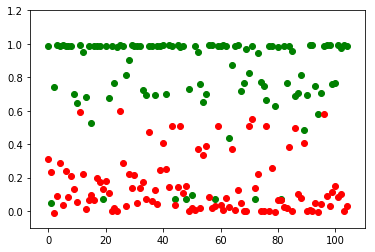

In [56]:
print('Event Tweets (A): ', event_tweet_count('nationaldonutday'))
A, B = tweets_event_ab_test('nationaldonutday')
plt.scatter(range(len(A)), A, c = 'g')
plt.scatter(range(len(B)), B, c = 'r')
plt.ylim(-.1,1.2)

In [120]:
Top_scored_tweets_in_B('nbafinals', n = 300000)

,score,tweet
283529,0.787956,i miss first period with malia. where you been
116205,0.787956,i miss getting my period
612,0.784132,bathing whilst on my period. a literal #bloodbath
27047,0.784132,latvians my draft specialty.
234689,0.784132,please draft


In [ ]:
Top_scored_tweets_in_B('nationaldonutday', n = 300000)

In [ ]:
Top_scored_tweets_in_B('travel ban|travelban', n = 300000)